# Malware Detection using RGB images and CNN

###  Imports

In [1]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Path to DB
path_root = "data_rbg_120dpi"

### Load Data

In [3]:
from os import listdir
from os.path import isfile, join, exists

def get_filenames(path):
    onlyfiles = [path+f for f in listdir(path) if isfile(join(path, f))]
    return onlyfiles

category_names=listdir(path_root) 
for i in range(len(category_names)):
    print(category_names[i],'=',i)
print('total categories:',len(category_names))

benign = 0
malicious = 1
total categories: 2


In [4]:
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=300)
imgs, labels = next(batches)
# normalized by /255
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.25)

Found 272 images belonging to 2 classes.


In [5]:
print(f"X_train.shape:{X_train.shape},  y_train.shape:{y_train.shape}")
print(f"X_test.shape:{X_test.shape},  y_test.shape:{y_test.shape}")

X_train.shape:(204, 64, 64, 3),  y_train.shape:(204, 2)
X_test.shape:(68, 64, 64, 3),  y_test.shape:(68, 2)


## CNN using Tensorflow Subclassing

In [6]:
class CNNBlock(layers.Layer):
    def __init__(self, out_channels, kernel_size=3):
        super(CNNBlock, self).__init__()
        self.conv = layers.Conv2D(out_channels, kernel_size, padding='same', activation='relu')
        

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = tf.nn.relu(x)
        return x

In [7]:
class ResBlock(layers.Layer):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.cnn1 = CNNBlock(channels[0])
        self.cnn2 = CNNBlock(channels[1])
        self.cnn3 = CNNBlock(channels[2])
        self.pooling = layers.MaxPooling2D()
        self.identity_mapping = layers.Conv2D(channels[1], 3, padding='same')

    def call(self, input_tensor, training=False):
        x = self.cnn1(input_tensor, training=training)
        x = self.cnn2(x, training=training)
        x = self.cnn3(
            x + self.identity_mapping(input_tensor), training=training,
        )
        return self.pooling(x)

In [8]:
class ResNet_Like(keras.Model):
    def __init__(self, num_classes=2):
        super(ResNet_Like, self).__init__()
        self.block1 = ResBlock([32, 32 , 64])
        self.block2 = ResBlock([64, 64 , 128])
        #self.block3 = ResBlock([128, 256 , 512])
        self.pool = layers.MaxPooling2D()
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(128, activation='relu')
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, input_tensor, training=False):
        x = self.block1(input_tensor, training=training)
        x = self.block2(x, training=training)
        #x = self.block3(x, training=training)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.classifier(x)

### Build, fit and evaluate model

In [25]:
model = ResNet_Like(num_classes=2)

In [26]:
model.compile(
    optimizer = tf.keras.optimizers.Adamax(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
             tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
             tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives() ]
)
    

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=64, epochs=50)

Epoch 1/50
4/4 [==============================] - 2s 250ms/step - loss: 1.0163 - accuracy: 0.5637 - precision_3: 0.5637 - recall_3: 0.5637 - true_positives_3: 115.0000 - true_negatives_3: 115.0000 - false_positives_3: 89.0000 - false_negatives_3: 89.0000 - val_loss: 0.6640 - val_accuracy: 0.7059 - val_precision_3: 0.7059 - val_recall_3: 0.7059 - val_true_positives_3: 48.0000 - val_true_negatives_3: 48.0000 - val_false_positives_3: 20.0000 - val_false_negatives_3: 20.0000
Epoch 2/50
4/4 [==============================] - 0s 97ms/step - loss: 0.6326 - accuracy: 0.6814 - precision_3: 0.6814 - recall_3: 0.6814 - true_positives_3: 139.0000 - true_negatives_3: 139.0000 - false_positives_3: 65.0000 - false_negatives_3: 65.0000 - val_loss: 0.5766 - val_accuracy: 0.7206 - val_precision_3: 0.7206 - val_recall_3: 0.7206 - val_true_positives_3: 49.0000 - val_true_negatives_3: 49.0000 - val_false_positives_3: 19.0000 - val_false_negatives_3: 19.0000
Epoch 3/50
4/4 [==============================] -

4/4 [==============================] - 0s 102ms/step - loss: 0.2638 - accuracy: 0.8873 - precision_3: 0.8873 - recall_3: 0.8873 - true_positives_3: 181.0000 - true_negatives_3: 181.0000 - false_positives_3: 23.0000 - false_negatives_3: 23.0000 - val_loss: 0.3324 - val_accuracy: 0.8971 - val_precision_3: 0.8971 - val_recall_3: 0.8971 - val_true_positives_3: 61.0000 - val_true_negatives_3: 61.0000 - val_false_positives_3: 7.0000 - val_false_negatives_3: 7.0000
Epoch 19/50
4/4 [==============================] - 0s 101ms/step - loss: 0.3066 - accuracy: 0.8824 - precision_3: 0.8824 - recall_3: 0.8824 - true_positives_3: 180.0000 - true_negatives_3: 180.0000 - false_positives_3: 24.0000 - false_negatives_3: 24.0000 - val_loss: 0.2841 - val_accuracy: 0.8824 - val_precision_3: 0.8824 - val_recall_3: 0.8824 - val_true_positives_3: 60.0000 - val_true_negatives_3: 60.0000 - val_false_positives_3: 8.0000 - val_false_negatives_3: 8.0000
Epoch 20/50
4/4 [==============================] - 0s 101ms/st

4/4 [==============================] - 0s 100ms/step - loss: 0.1590 - accuracy: 0.9363 - precision_3: 0.9363 - recall_3: 0.9363 - true_positives_3: 191.0000 - true_negatives_3: 191.0000 - false_positives_3: 13.0000 - false_negatives_3: 13.0000 - val_loss: 0.2312 - val_accuracy: 0.8971 - val_precision_3: 0.8971 - val_recall_3: 0.8971 - val_true_positives_3: 61.0000 - val_true_negatives_3: 61.0000 - val_false_positives_3: 7.0000 - val_false_negatives_3: 7.0000
Epoch 36/50
4/4 [==============================] - 0s 97ms/step - loss: 0.1291 - accuracy: 0.9608 - precision_3: 0.9608 - recall_3: 0.9608 - true_positives_3: 196.0000 - true_negatives_3: 196.0000 - false_positives_3: 8.0000 - false_negatives_3: 8.0000 - val_loss: 0.2552 - val_accuracy: 0.8971 - val_precision_3: 0.8971 - val_recall_3: 0.8971 - val_true_positives_3: 61.0000 - val_true_negatives_3: 61.0000 - val_false_positives_3: 7.0000 - val_false_negatives_3: 7.0000
Epoch 37/50
4/4 [==============================] - 0s 95ms/step -

In [12]:
model.summary()

Model: "res_net__like"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_block (ResBlock)        multiple                  29536     
                                                                 
 res_block_1 (ResBlock)      multiple                  184640    
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  1048704   
                                                                 
 dense_1 (Dense)             multiple                  258       
                                                     

In [28]:
model.evaluate(X_test, y_test, batch_size=64, verbose=2)

2/2 - 0s - loss: 0.1672 - accuracy: 0.9412 - precision_3: 0.9412 - recall_3: 0.9412 - true_positives_3: 64.0000 - true_negatives_3: 64.0000 - false_positives_3: 4.0000 - false_negatives_3: 4.0000 - 294ms/epoch - 147ms/step


[0.16723524034023285,
 0.9411764740943909,
 0.9411764740943909,
 0.9411764740943909,
 64.0,
 64.0,
 4.0,
 4.0]

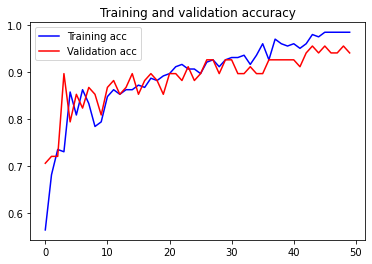

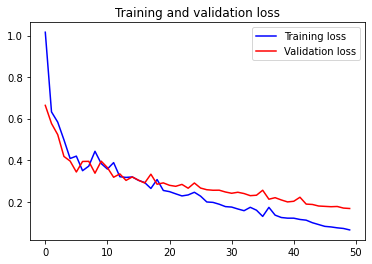

In [29]:
# Utility function for plotting of the model results
import matplotlib.pyplot as plt
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


# Run the function to illustrate accuracy and loss
visualize_results(history)

In [ ]:
# tf.saved_model.save(model, 'model_rgb')
# imported = tf.saved_model.load('model_rgb')

#### Classification report

In [30]:
from sklearn.metrics import classification_report
import numpy as np

Y_VAL = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(Y_VAL, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        32
           1       0.97      0.92      0.94        36

    accuracy                           0.94        68
   macro avg       0.94      0.94      0.94        68
weighted avg       0.94      0.94      0.94        68

